In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import ( basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz,destroy,
                   tensor)
from qutip.solver import heom
from scipy.integrate import quad
from pseudomode import pseudomode,zero_temp_bath

In [17]:
# Set the system parameters
N = 2
g=1
J=5*g
# initial state
state_list = [basis(2, 1)] + [basis(2, 0)] * (N - 1)
psi0 = tensor(state_list)


sx_list, sy_list, sz_list = [], [], []
for i in range(N):
    op_list = [qeye(2)] * N
    op_list[i] = sigmax()
    sx_list.append(tensor(op_list))
    op_list[i] = sigmay()
    sy_list.append(tensor(op_list))
    op_list[i] = sigmaz()
    sz_list.append(tensor(op_list))

# Hamiltonian - Energy splitting terms
H = 0
for i in range(N):
    H += g* sz_list[i]

for n in range(N - 1):
    H += -J* sx_list[n] * sx_list[n + 1]

In [18]:
E01=H.eigenenergies()[2]-H.eigenenergies()[0]# Raise this question about the paper 
gamma=3.8*g
w0=1.2*E01
Gamma=gamma/2
Omega=np.sqrt(w0**2 -Gamma**2)
lam=1.15*g*np.sqrt(Omega)

In [19]:
2*w0>gamma

True

In [20]:
Q=sz_list[-1]+ 1.1*sy_list[-1]+0.9*sz_list[-1]

In [21]:
time=np.linspace(0,10,5000)
bathu=zero_temp_bath(Q,time,lam,gamma,w0)

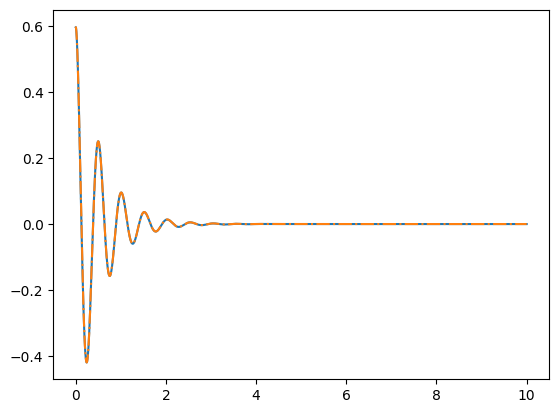

In [22]:
plt.plot(time,np.real(bathu.correlation_function))
plt.plot(time,np.real(bathu.fbath.correlation_function_approx(time)),"-.")
plt.show()

In [23]:
bath=heom.UnderDampedBath(Q,lam,gamma,w0,1e-30,5) # functions don't take zero because 1/T should be fixed
times2=np.linspace(0,20,1000)
cfiitter2=heom.CorrelationFitter(Q,0,times2,bath.correlation_function)
fit2=cfiitter2.get_fit(Ni=1,Nr=2)
print(fit2[1]['summary']) #notice one mode is also a pretty good approximation

Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 2 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         |-6.67e-02 |-1.07e+01 |9.84e-09                              | 1         |-6.61e-01 |-1.90e+00 |1.23e+01                              
 2         | 6.67e-01 |-1.91e+00 |1.23e+01                              |                                                                        
                                                                        |A  normalized RM

In [24]:
times=np.linspace(0,50,500)
solver = heom.HEOMSolver(H,
                    [fit2[0]], max_depth=3,options={"atol":1e-14})
result = solver.run(psi0*psi0.dag(), times)

10.0%. Run time:   0.22s. Est. time left: 00:00:00:01
20.0%. Run time:   0.33s. Est. time left: 00:00:00:01
30.1%. Run time:   0.44s. Est. time left: 00:00:00:01
40.1%. Run time:   0.55s. Est. time left: 00:00:00:00
50.1%. Run time:   0.66s. Est. time left: 00:00:00:00
60.1%. Run time:   0.77s. Est. time left: 00:00:00:00
70.1%. Run time:   0.87s. Est. time left: 00:00:00:00
80.2%. Run time:   0.98s. Est. time left: 00:00:00:00
90.2%. Run time:   1.09s. Est. time left: 00:00:00:00
100.0%. Run time:   1.19s. Est. time left: 00:00:00:00
Total run time:   1.19s


In [25]:
sdd=[(i*H).tr() for i in result.states]

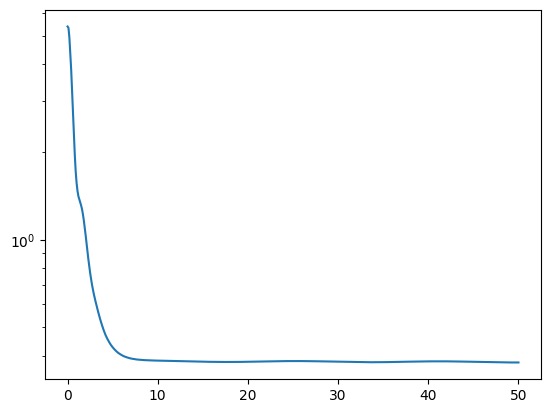

In [26]:
plt.plot(times,sdd-np.min(H.eigenenergies()))
plt.yscale("log")

In [27]:
time=np.linspace(0,150,10000)
bathu=zero_temp_bath(Q,time,lam,gamma,w0,N=1)

In [28]:
print(bathu.finfo["summary"])

Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 1 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         |-5.70e-02 |-9.10e+00 |1.43e-12                              | 1         | 0.00e+00 | 0.00e+00 |0.00e+00                              
                                                                        |                                                                        
A  normalized RMSE of  2.55e-05 was obtained for the The Real Part Of   |A  normalized RM

better check power spectrums

In [48]:
example=pseudomode(Hsys=H, Q=Q,bath=bathu)

In [30]:
ans=example.evolution(psi0,3,times,e_ops=[H],options={"atol":1e-14,"normalize_output":False})

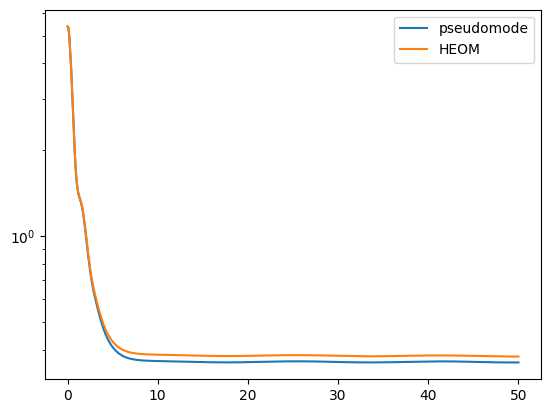

In [31]:
plt.plot(times,ans.expect[0]-np.min(H.eigenenergies()),label="pseudomode")
plt.plot(times,sdd-np.min(H.eigenenergies()),label="HEOM")
plt.legend()
plt.yscale("log")

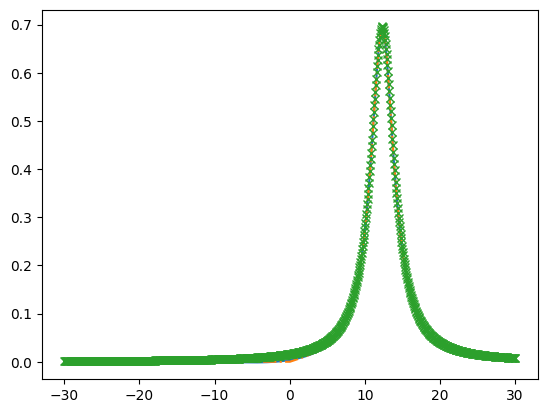

In [32]:
a=np.linspace(-30,30,1000)
plt.plot(a,-example.power_spectrum(a))
plt.plot(a,bath.power_spectrum(a),"-.")
plt.plot(a,bath.power_spectrum_approx(a),"x")

In [49]:
example2 = pseudomode(Hsys=H, Q=Q,bath=fit2[0])
#ans2 = example.evolution(psi0,4,times,e_ops=[H],options={"atol":1e-14,"normalize_output":False})

In [50]:
bath.exponents

[<BathExponent type=RI dim=None Q.dims=[[2, 2], [2, 2]] ck=(0.33062500000000006+0j) vk=(1.9-12.316508158676177j) ck2=0.33062500000000006j sigma_bar_k_offset=None fermionic=False tag=None>,
 <BathExponent type=RI dim=None Q.dims=[[2, 2], [2, 2]] ck=(0.33062500000000006+0j) vk=(1.9+12.316508158676177j) ck2=-0.33062500000000006j sigma_bar_k_offset=None fermionic=False tag=None>,
 <BathExponent type=R dim=None Q.dims=[[2, 2], [2, 2]] ck=(-4.837148754840326e-61+0j) vk=6.283185307179587e-30 ck2=None sigma_bar_k_offset=None fermionic=False tag=None>]

In [51]:
fit2[0].exponents

[<BathExponent type=R dim=None Q.dims=[[2, 2], [2, 2]] ck=(-0.03336136924038501+0j) vk=(10.680809235957097-9.842262000368976e-09j) ck2=None sigma_bar_k_offset=None fermionic=False tag=None>,
 <BathExponent type=R dim=None Q.dims=[[2, 2], [2, 2]] ck=(0.33362349707611244+0j) vk=(1.9136861797267555-12.312097530649472j) ck2=None sigma_bar_k_offset=None fermionic=False tag=None>,
 <BathExponent type=R dim=None Q.dims=[[2, 2], [2, 2]] ck=(-0.03336136924038501-0j) vk=(10.680809235957097+9.842262000368976e-09j) ck2=None sigma_bar_k_offset=None fermionic=False tag=None>,
 <BathExponent type=R dim=None Q.dims=[[2, 2], [2, 2]] ck=(0.33362349707611244-0j) vk=(1.9136861797267555+12.312097530649472j) ck2=None sigma_bar_k_offset=None fermionic=False tag=None>,
 <BathExponent type=I dim=None Q.dims=[[2, 2], [2, 2]] ck=0.33062500012848417j vk=(1.9000000012615244-12.316508158430155j) ck2=None sigma_bar_k_offset=None fermionic=False tag=None>,
 <BathExponent type=I dim=None Q.dims=[[2, 2], [2, 2]] ck=-0.

In [52]:
example.vks

array([-9.09617907+1.43472292e-12j, -1.9       +1.23165082e+01j])

In [53]:
example2.vks

array([-10.68080924+9.84226200e-09j,  -1.91368618+1.23120975e+01j,
        -1.9       +1.23165082e+01j])

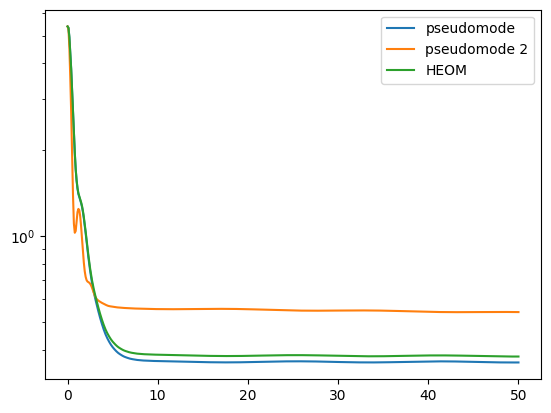

In [38]:
plt.plot(times, ans.expect[0]-np.min(H.eigenenergies()), label="pseudomode")
plt.plot(times, ans2.expect[0]-np.min(H.eigenenergies()), label="pseudomode 2")
plt.plot(times, sdd-np.min(H.eigenenergies()), label="HEOM")
plt.legend()
plt.yscale("log")